# Overview
 - Writing optimizer machine learning cose with Theano
 - Choosing activation function for artificial neural networks
 - Using the Keras deep learning library for fast and easy experimentation
 
 USING Python 2.7
 
 (may be using GPU, reason soooo slow? (my GPU sucks)

## Building, compiling, and running expressions with Theano

In [1]:
import theano

In [2]:
from theano import tensor as T

In [7]:
## compute net input z of a sample point x, w1 weight 1, w0 bias
## z = x1 * w1 + w0

# initialize
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# compile
net_input = theano.function(inputs=[w1, x1, w0],
                            outputs=z1)

# execute
print('Net input: %.2f' % net_input(2.0, 1.0, 5.0))

KeyboardInterrupt: 

In [9]:
print(theano.config.floatX)

float32


In [6]:
## changing to float32
theano.config.floatX = 'float32'
#can apply these settings only to a particular Python script, 
# by running it as follows:
# THEANO_FLAGS=floatX=float32 python your_script.py

In [10]:
## check if using CPU or GPU
print(theano.config.device)

cpu


My personal recommendation is to use cpu as default, which makes prototyping and code debugging easier. For example, you can run Theano code on your CPU by executing it as a script, as from your command-line terminal:

THEANO_FLAGS=device=cpu,floatX=float64 python your_script.py

However, once we have implemented the code and want to run it most efficiently utilizing our GPU hardware, we can then run it via the following code without making additional modifications to our original code:

THEANO_FLAGS=device=gpu,floatX=float32 python your_script.py

It may also be convenient to create a .theanorc file in your home directory to make these configurations permanent. For example, to always use float32 and the GPU, you can create such a .theanorc file including these settings. The command is as follows:

echo -e "\n[global]\nfloatX=float32\ndevice=gpu\n" >> ~/.theanorc

If you are not operating on a MacOS X or Linux terminal, you can create a .theanorc file manually using your favorite text editor and add the following contents:


[global]
floatX=float32
device=gpu

### Working with array structures
- array structures in Theano using tensor module
- create simple 2x3 matrix, and calculate column sum

In [11]:
import numpy as np

# initialize
# if running 64 but mode,
# need to use dmatrix instead of fmatrix
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

In [12]:
# compile
calc_sum = theano.function(inputs=[x], outputs=x_sum)

KeyboardInterrupt: 

In [ ]:
# execute (Python list)
ary = [[1,2,3], [1,2,3]]
print('Column sum:', calc_sum(ary))
# Column sum: [2. 4. 6.]

In [15]:
# execute (NumPy Array)
ary = np.array([[1,2,3], [1,2,3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))
# Column sun: [2. 4. 6.]

NameError: name 'calc_sum' is not defined

In [18]:
## 'shared' variable
## allows us to spread large objects (arrays) and grants multiple
## functions read and write access, so can perform updats on those
## objects after compilation

# initialize
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]],
                            dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

In [20]:
# compile
net_input = theano.function(inputs=[x],
                           updates=update,
                           outputs=z)

KeyboardInterrupt: 

In [ ]:
# execute
data = np.array([[1,2,3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d' % i, net_input(data))
# z0: [[ 0.]]
# z1: [[ 6.]]
# z2: [[ 12.]]
# z3: [[ 18.]]
# z4: [[ 24.]]

## 'givens' variable
insert values into the graph before compiling it.
which can reduce the number of transfers from RAM over CPUs to GPUs. If we use the inputs parameter in theano.function, data is transferred from the CPU to the GPU multiple times, for example, if we iterate over a dataset multiple times (epochs) during gradient descent. Using givens, we can keep the dataset on the GPU if it fits into its memory (for example, if we are learning with mini-batches).


In [21]:
# initialize
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]],
                            dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

In [22]:
# compile
net_input = theano.function(inputs=[],
                           updates=update,
                           givens={x:data},
                           outputs=z)

KeyboardInterrupt: 

In [24]:
# execute
for i in range(5):
    print('z:' net_input())
# z0: [[ 0.]]
# z1: [[ 6.]]
# z2: [[ 12.]]
# z3: [[ 18.]]
# z4: [[ 24.]]

### Wrapping things up - a linear regression example

In [25]:
## ordinary least squares regression
X_train = np.asarray([[0.0], [1.0], 
                      [2.0], [3.0], 
                      [4.0], [5.0], 
                      [6.0], [7.0], 
                      [8.0], [9.0]], 
                     dtype=theano.config.floatX)
y_train = np.asarray([1.0, 1.3, 
                      3.1, 2.0, 
                      5.0, 6.3, 
                      6.6, 7.4, 
                      8.0, 9.0], 
                     dtype=theano.config.floatX)

In [26]:
import theano
from theano import tensor as T
import numpy as np

def train_linreg(X_train, y_train, eta, epochs):

    costs = []
    # Initialize arrays
    eta0 = T.fscalar('eta0')
    y = T.fvector(name='y') 
    X = T.fmatrix(name='X')   
    w = theano.shared(np.zeros(
                        shape=(X_train.shape[1] + 1),
                        dtype=theano.config.floatX),
                      name='w')
    
    # calculate cost
    net_input = T.dot(X, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2)) 

    # perform gradient update
    gradient = T.grad(cost, wrt=w)
    update = [(w, w - eta0 * gradient)]

    # compile model
    train = theano.function(inputs=[eta0],
                            outputs=cost,
                            updates=update,
                            givens={X: X_train,
                                    y: y_train,})      
    
    for _ in range(epochs):
        costs.append(train(eta))
    
    return costs, w

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
plt.plot(range(1, len(costs)+1), costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()
# converged after 5th epoch

KeyboardInterrupt: 

In [ ]:
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt], 
                              givens={w: w}, 
                              outputs=net_input)
    return predict(X)

In [ ]:
plt.scatter(X_train, 
            y_train, 
            marker='s', 
            s=50)
plt.plot(range(X_train.shape[0]), 
         predict_linreg(X_train, w), 
         color='gray', 
         marker='o', 
         markersize=4, 
         linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Choosing activation functions for feedforward neural networks

#### Logistic funciton recap

In [30]:
X = np.array([[1, 1.4, 1.5]])
w = np.array([0.0, 0.2, 0.4])

def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    # sigmoid of net input
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)[0])

P(y=1|x) = 0.707


In [32]:
# W : array, shape = [n_output_units, n_hidden_units+1]
#          Weight matrix for hidden layer -> output layer.
# note that first column (A[:][0] = 1) are the bias units
W = np.array([[1.1, 1.2, 1.3, 0.5],
              [0.1, 0.2, 0.4, 0.1],
              [0.2, 0.5, 2.1, 1.9]])
# A : array, shape = [n_hidden+1, n_samples]
#          Activation of hidden layer.
# note that first element (A[0][0] = 1) is the bias unit
A = np.array([[1.0],
              [0.1],
              [0.3],
              [0.7]])
# Z : array, shape = [n_output_units, n_samples]
#          Net input of the output layer.
Z = W.dot(A)
y_probas = logistic(Z)
print 'Probabilities:\n', y_probas 

Probabilities:
[[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]


In [34]:
## if predicting class labels
## will choose class with highest probability
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


#### Estimating probabilities in multi-class classification via the softmax function

In [36]:
## softmax
## notice probs sum to 1 due to normalization
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    z = net_input(X, w)
    return softmax(z)

y_probas = softmax(Z)
print 'Probabilities:\n', y_probas

Probabilities:
[[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]


In [38]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


#### Broadening the output spectrum by using hyperbolic tangent (tanh)

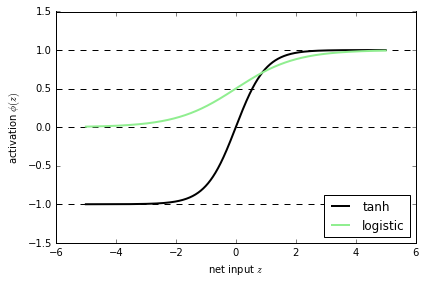

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z) #logistic activation
tanh_act = tanh(z) #tanh activiation

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')
plt.plot(z, tanh_act,
        linewidth=2,
        color='black',
        label='tanh')
plt.plot(z, log_act,
        linewidth=2,
        color='lightgreen',
        label='logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# hyperbolic tangent in numpy
# tanh_act = np.tanh(z)

## logistic function in scipy.special
# from scipy.special import expit
# log_act = expit(z)